In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from data_preprocessing import process_resstock_data
from models import MLPModel

# Load data

### Setpoint timeseries

In [2]:
# full_heating_timeseries, full_cooling_timeseries = generate_setpoint_timeseries(
#     cooling_start_date = "2018-06-01",
#     cooling_end_date = "2018-10-31",
#     combine = False
# )

In [3]:
# # Save heaitng and cooling timeseries to pickle
# with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_heating_timeseries.pkl', 'wb') as f:
#     pickle.dump(full_heating_timeseries, f)
# with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_cooling_timeseries.pkl', 'wb') as f:
#     pickle.dump(full_cooling_timeseries, f)

In [4]:
# Load full heating and cooling timeseries
with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_heating_timeseries.pkl', 'rb') as f:
    full_heating_timeseries = pickle.load(f)
with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_cooling_timeseries.pkl', 'rb') as f:
    full_cooling_timeseries = pickle.load(f)

### Weather data

In [5]:
weather_data = pd.read_csv("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/G2500170_2018.csv")

### ResStock

In [6]:
resstock = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/MA_baseline_metadata_and_annual_results.parquet")

### Building timeseries

In [7]:
building_data = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/1000-0.parquet")

### Setpoint timeseries plot

In [8]:
heating_timeseries = full_heating_timeseries[1000]
cooling_timeseries = full_cooling_timeseries[1000]

heating_timeseries = pd.concat([heating_timeseries.loc["2018-01-01":"2018-05-31"], heating_timeseries.loc["2018-11-01":"2018-12-31"]])
cooling_timeseries = cooling_timeseries.loc["2018-06-01":"2018-10-31"]

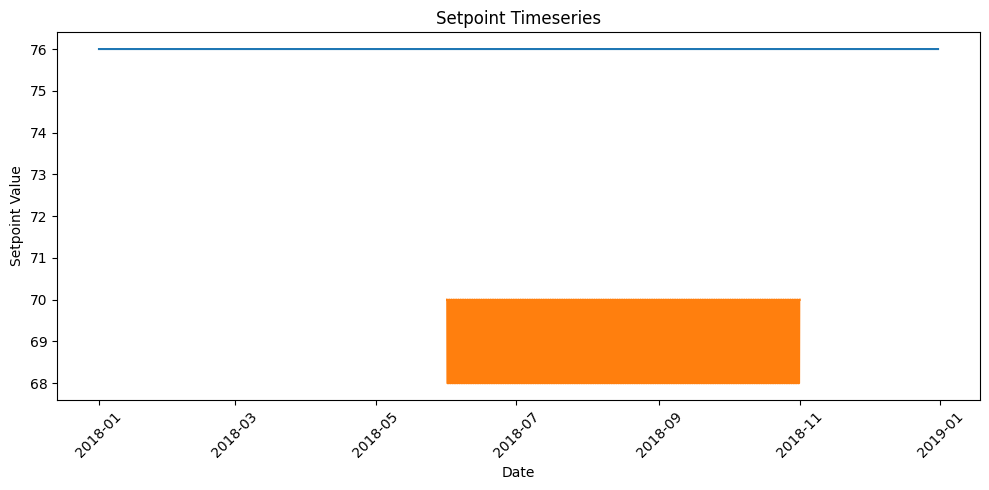

In [9]:
# Plot the timeseries
plt.figure(figsize=(10, 5))
plt.plot(heating_timeseries.index, heating_timeseries["setpoint"])
plt.plot(cooling_timeseries.index, cooling_timeseries["setpoint"])
plt.title("Setpoint Timeseries")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ResStock transform

In [10]:
columns = [
    "in.bedrooms",              # int
    "in.duct_leakage_and_insulation",    # Separate into leakage / insulation: X% / (Uniinsulated/R-n)
    "in.duct_location",         # Places of the house
    "in.geometry_floor_area",   # 1000-1499, ...
    "in.geometry_stories",      # int
    "in.geometry_wall_type",    # Materials
    "in.ground_thermal_conductivity",   # float
    "in.hvac_has_ducts",    # Yes / No
    "in.insulation_ceiling",    # R-n / Uninsulated
    "in.insulation_floor",      # R-n / Uninsulated
    "in.insulation_foundation_wall",    # Wall R-n, Exterior
    "in.insulation_roof",       # Finished / Unfinished, R-n
    "in.insulation_wall",       # Material, Uninsulated / R-n
    "in.occupants",         # int
    "in.orientation",       # North, Northwest...
    "in.roof_material",     # Material
    "in.sqft",              # int
    "in.windows"    # Single/Double/Triple, Low-E/Clear, Metal/Non-metal, Air/Exterior Clear Storm, (L/M-Gain)
    "in.window_areas",
    "in.vintage",
]

In [11]:
columns_processed = [
    "in.bedrooms_processed",              # int
    "in.duct_leakage_processed",
    "in.duct_insulation_processed",    # Separate into leakage / insulation: X% / (Uniinsulated/R-n)
    "in.duct_location_processed",         # Places of the house
    "in.geometry_floor_area_processed",   # 1000-1499, ...
    "in.geometry_stories_processed",      # int
    "in.geometry_wall_type_processed",    # Materials
    "in.ground_thermal_conductivity_processed",   # float
    "in.hvac_has_ducts_processed",    # Yes / No
    "in.insulation_ceiling_processed",    # R-n / Uninsulated
    "in.insulation_floor_processed",      # R-n / Uninsulated
    "in.insulation_foundation_wall_processed",    # Wall R-n, Exterior
    "in.insulation_roof_processed",       # Finished / Unfinished, R-n
    "in.insulation_wall_processed",       # Material, Uninsulated / R-n
    "in.occupants_processed",         # int
    "in.orientation_processed",       # North, Northwest...
    "in.roof_material_processed",     # Material
    "in.sqft_processed",              # int
    "in.windows_processed", # Single/Double/Triple, Low-E/Clear, Metal/Non-metal, Air/Exterior Clear Storm, (L/M-Gain)
    "in.window_areas_processed",
    "in.vintage_processed",
    
]

In [12]:
resstock_processed = process_resstock_data(resstock)

In [13]:
resstock_processed["in.vintage_processed"].value_counts()

in.vintage_processed
1930    3820
1970    1386
1950    1312
1980    1269
1960    1220
1990     895
2000     825
1940     614
2010     366
Name: count, dtype: int64

In [14]:
usable_resstock = resstock_processed[columns_processed]

In [15]:
usable_resstock.head()

,in.bedrooms_processed,in.duct_leakage_processed,in.duct_insulation_processed,in.duct_location_processed,in.geometry_floor_area_processed,in.geometry_stories_processed,in.geometry_wall_type_processed,in.ground_thermal_conductivity_processed,in.hvac_has_ducts_processed,in.insulation_ceiling_processed,...,in.insulation_foundation_wall_processed,in.insulation_roof_processed,in.insulation_wall_processed,in.occupants_processed,in.orientation_processed,in.roof_material_processed,in.sqft_processed,in.windows_processed,in.window_areas_processed,in.vintage_processed
bldg_id,,,,,,,,,,,,,,,,,,,,,
10,3,10,0,4,1749,1,1,1.4,1,5,...,1,0,0,6,1,3,1228,2,18,1950
122,1,0,0,0,874,5,1,1.4,0,0,...,1,6,0,1,5,0,623,2,18,1950
129,1,0,0,0,874,2,2,1.1,0,0,...,1,5,1,1,4,0,623,1,15,1970
150,2,0,0,0,1749,3,1,1.1,0,0,...,0,3,4,1,3,0,1138,2,15,2000
183,3,0,0,0,1749,1,1,1.4,0,1,...,1,0,0,2,3,1,1228,2,18,1930


In [16]:
building_resstock = np.array(usable_resstock.loc[1000])

In [17]:
building_resstock

array([3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.499e+03, 1.000e+00,
       2.000e+00, 1.400e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
       5.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.682e+03,
       2.000e+00, 1.500e+01, 1.930e+03])

# Transform data

In [18]:
def get_cols(building_data: pd.DataFrame, building_id: int) -> str:

    try:
        building = building_data.loc[building_id]
    except:
        raise ValueError("Building ID not found in the dataset")

    match building["in.heating_fuel"]:
        case  "Natural Gas":
            return "out.natural_gas.heating.energy_consumption"
        case "Electricity":
            return "out.electricity.heating.energy_consumption"
        case "Fuel Oil":
            return "out.fuel_oil.heating.energy_consumption"
        case "Propane":
            return "out.propane.heating.energy_consumption"
        case _:
            return "out.electricity.heating.energy_consumption"

In [19]:
weather_data.columns

Index(['date_time', 'Dry Bulb Temperature [°C]', 'Relative Humidity [%]',
       'Wind Speed [m/s]', 'Wind Direction [Deg]',
       'Global Horizontal Radiation [W/m2]', 'Direct Normal Radiation [W/m2]',
       'Diffuse Horizontal Radiation [W/m2]'],
      dtype='object')

In [20]:
# Change date time column name to timestamp
weather_data.rename(columns={'date_time': "timestamp"}, inplace=True)
weather_data.set_index('timestamp', inplace=True)
weather_data.index = pd.to_datetime(weather_data.index)

# Delete all columns except dry bulb temperature
weather_data = weather_data[["Dry Bulb Temperature [°C]", "Direct Normal Radiation [W/m2]"]]
weather_data.rename(columns={"Dry Bulb Temperature [°C]": "temperature"}, inplace=True)

# Create an entry for 2018-01-01 00:00:00
new_row = pd.DataFrame({'temperature': weather_data.iloc[0]['temperature']}, index=[pd.to_datetime('2018-01-01 00:00:00')])
weather_data = pd.concat([new_row, weather_data])

# Remove last 19 rows
weather_data = weather_data[:-24]

In [21]:
weather_data.bfill(inplace=True)
weather_data.ffill(inplace=True)

In [22]:
building_id = 1000

In [23]:
col_to_use = get_cols(resstock, building_id)
consumption_timeseries = building_data[["timestamp", col_to_use]]

# Resample to hourly data
consumption_timeseries["timestamp"] = pd.to_datetime(consumption_timeseries["timestamp"])
consumption_timeseries.set_index("timestamp", inplace=True)
consumption_timeseries = consumption_timeseries.resample("H").mean()
consumption_timeseries = consumption_timeseries[col_to_use]

consumption_timeseries = consumption_timeseries[:-24]

# Turn into dataframe
consumption_timeseries = pd.DataFrame(consumption_timeseries)
consumption_timeseries.rename(columns={col_to_use: "consumption"}, inplace=True)

/var/folders/bw/4qyc6pj92bdb1bv22yhll2zw0000gn/T/ipykernel_4118/3969840236.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumption_timeseries["timestamp"] = pd.to_datetime(consumption_timeseries["timestamp"])
/var/folders/bw/4qyc6pj92bdb1bv22yhll2zw0000gn/T/ipykernel_4118/3969840236.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  consumption_timeseries = consumption_timeseries.resample("H").mean()


In [24]:
exog_variables = pd.merge(
    consumption_timeseries,
    weather_data,
    left_index=True,
    right_index=True,
)

In [25]:
heating_exog = exog_variables.loc[heating_timeseries.index]
cooling_exog = exog_variables.loc[cooling_timeseries.index]

# Data Plot

In [26]:
train_size = 0.8
heating_endog_train = heating_timeseries[:int(train_size * len(heating_timeseries))]
heating_endog_test = heating_timeseries[int(train_size * len(heating_timeseries)):]

heating_exog_train = heating_exog[:int(train_size * len(heating_exog))]
heating_exog_test = heating_exog[int(train_size * len(heating_exog)):]

cooling_endog_train = cooling_timeseries[:int(train_size * len(cooling_timeseries))]
cooling_endog_test = cooling_timeseries[int(train_size * len(cooling_timeseries)):]

cooling_exog_train = cooling_exog[:int(train_size * len(cooling_exog))]
cooling_exog_test = cooling_exog[int(train_size * len(cooling_exog)):]

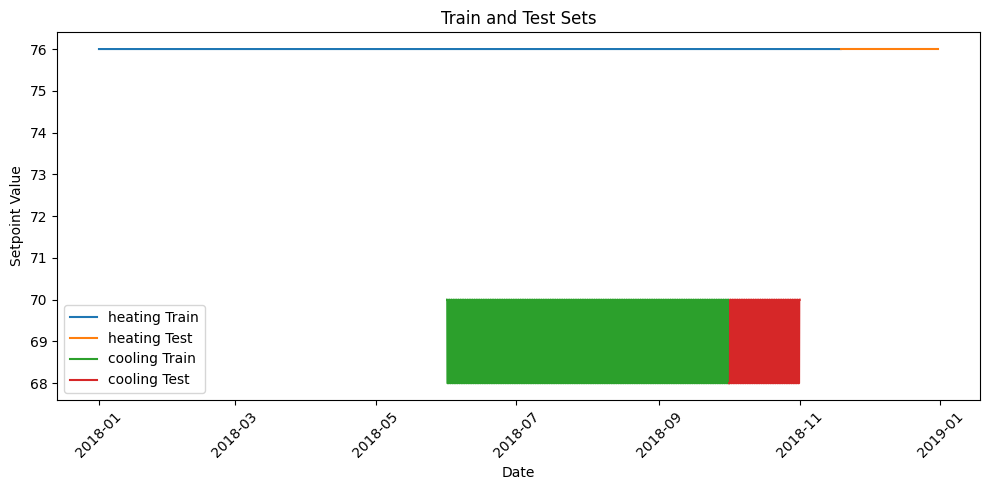

In [27]:
# Plot the training and test sets
plt.figure(figsize=(10, 5))
plt.plot(heating_endog_train.index, heating_endog_train["setpoint"], label="heating Train")
plt.plot(heating_endog_test.index, heating_endog_test["setpoint"], label="heating Test")
plt.plot(cooling_endog_train.index, cooling_endog_train["setpoint"], label="cooling Train")
plt.plot(cooling_endog_test.index, cooling_endog_test["setpoint"], label="cooling Test")
plt.title("Train and Test Sets")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Datasets and Dataloaders

In [28]:
heating_train_timeseries = pd.merge(heating_endog_train, heating_exog_train, left_index=True, right_index=True)
heating_test_timeseries = pd.merge(heating_endog_test, heating_exog_test, left_index=True, right_index=True)

cooling_train_timeseries = pd.merge(cooling_endog_train, cooling_exog_train, left_index=True, right_index=True)
cooling_test_timeseries = pd.merge(cooling_endog_test, cooling_exog_test, left_index=True, right_index=True)

In [29]:
heating_train_timeseries.head()

,setpoint,consumption,temperature,Direct Normal Radiation [W/m2]
timestamp,,,,
2018-01-01 00:00:00,76.0,4.691970,-17.2,0.0
2018-01-01 01:00:00,76.0,5.008804,-17.2,0.0
2018-01-01 02:00:00,76.0,4.799112,-17.8,0.0
2018-01-01 03:00:00,76.0,4.963452,-18.9,0.0
2018-01-01 04:00:00,76.0,5.047929,-18.9,0.0


In [30]:
def create_lr_sequences(data, sequence_length, building_resstock):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length - 1):
        sequence = np.array(data.iloc[i:i+sequence_length])
        label = data.iloc[i+sequence_length].iloc[0]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), labels

In [31]:
sequence_length = 12
batch_size = 64

heating_train_sequences, heating_train_labels = create_lr_sequences(heating_train_timeseries, sequence_length, building_resstock)
heating_test_sequences, heating_test_labels = create_lr_sequences(heating_test_timeseries, sequence_length, building_resstock)

cooling_train_sequences, cooling_train_labels = create_lr_sequences(cooling_train_timeseries, sequence_length, building_resstock)
cooling_test_sequences, cooling_test_labels = create_lr_sequences(cooling_test_timeseries, sequence_length, building_resstock)

In [32]:
heating_train_sequences = heating_train_sequences.reshape(heating_train_sequences.shape[0], -1)
heating_test_sequences = heating_test_sequences.reshape(heating_test_sequences.shape[0], -1)

cooling_train_sequences = cooling_train_sequences.reshape(cooling_train_sequences.shape[0], -1)
cooling_test_sequences = cooling_test_sequences.reshape(cooling_test_sequences.shape[0], -1)

In [33]:
building_resstock_repeated_heating_train = np.tile(building_resstock, (heating_train_sequences.shape[0], 1))
building_resstock_repeated_heating_test = np.tile(building_resstock, (heating_test_sequences.shape[0], 1))

building_resstock_repeated_cooling_train = np.tile(building_resstock, (cooling_train_sequences.shape[0], 1))
building_resstock_repeated_cooling_test = np.tile(building_resstock, (cooling_test_sequences.shape[0], 1))

In [34]:
heating_train_sequences = np.concatenate((heating_train_sequences, building_resstock_repeated_heating_train), axis=1)
heating_test_sequences = np.concatenate((heating_test_sequences, building_resstock_repeated_heating_test), axis=1)

cooling_train_sequences = np.concatenate((cooling_train_sequences, building_resstock_repeated_cooling_train), axis=1)
cooling_test_sequences = np.concatenate((cooling_test_sequences, building_resstock_repeated_cooling_test), axis=1)

In [35]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


In [36]:
heating_train_dataset = TimeSeriesDataset(heating_train_sequences, heating_train_labels)
heating_test_dataset = TimeSeriesDataset(heating_test_sequences, heating_test_labels)
heating_train_loader = DataLoader(heating_train_dataset, batch_size=batch_size, shuffle=True)
heating_test_loader = DataLoader(heating_test_dataset, batch_size=batch_size, shuffle=False)

cooling_train_dataset = TimeSeriesDataset(cooling_train_sequences, cooling_train_labels)
cooling_test_dataset = TimeSeriesDataset(cooling_test_sequences, cooling_test_labels)
cooling_train_loader = DataLoader(cooling_train_dataset, batch_size=batch_size, shuffle=True)
cooling_test_loader = DataLoader(cooling_test_dataset, batch_size=batch_size, shuffle=False)

# Train and evaluate fns

In [37]:
# Training function
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for sequences, labels in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)  # Unsqueeze labels to match output dim
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

In [38]:
# Predict
def evaluate(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences)
            predictions.append(outputs.numpy())
            actuals.append(labels.numpy())
    return np.concatenate(predictions), np.concatenate(actuals)

In [39]:
len(heating_train_dataset[0][0])

69

# MLP

In [40]:
input_size = 69
hidden_size_1 = 64
hidden_size_2 = 32
output_size = 1

In [41]:
heating_model = MLPModel(
    input_size, 
    hidden_size_1=hidden_size_1, 
    hidden_size_2=hidden_size_2,
    output_size=output_size)

In [42]:
# Loss and optimizer
heating_criterion = nn.MSELoss()
heating_optimizer = optim.Adam(heating_model.parameters(), lr=0.0001)

## Heating

In [43]:
num_epochs = 100
train(heating_model, heating_train_loader, heating_criterion, heating_optimizer, num_epochs)

/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss: 66.2030
Epoch 2/100, Loss: 14.2934
Epoch 3/100, Loss: 8.9724
Epoch 4/100, Loss: 6.2330
Epoch 5/100, Loss: 4.7283
Epoch 6/100, Loss: 3.7777
Epoch 7/100, Loss: 3.0033
Epoch 8/100, Loss: 2.4077
Epoch 9/100, Loss: 1.9462
Epoch 10/100, Loss: 1.6073
Epoch 11/100, Loss: 1.2918
Epoch 12/100, Loss: 1.0431
Epoch 13/100, Loss: 0.8858
Epoch 14/100, Loss: 0.7784
Epoch 15/100, Loss: 0.6803
Epoch 16/100, Loss: 0.6114
Epoch 17/100, Loss: 0.5441
Epoch 18/100, Loss: 0.5041
Epoch 19/100, Loss: 0.4684
Epoch 20/100, Loss: 0.4186
Epoch 21/100, Loss: 0.3797
Epoch 22/100, Loss: 0.3634
Epoch 23/100, Loss: 0.3259
Epoch 24/100, Loss: 0.3208
Epoch 25/100, Loss: 0.2930
Epoch 26/100, Loss: 0.2670
Epoch 27/100, Loss: 0.2548
Epoch 28/100, Loss: 0.2497
Epoch 29/100, Loss: 0.2334
Epoch 30/100, Loss: 0.2100
Epoch 31/100, Loss: 0.2050
Epoch 32/100, Loss: 0.1905
Epoch 33/100, Loss: 0.2008
Epoch 34/100, Loss: 0.1788
Epoch 35/100, Loss: 0.1673
Epoch 36/100, Loss: 0.1568
Epoch 37/100, Loss: 0.1529
Epoch 38

In [44]:
# Predict
heating_predictions, heating_actuals = evaluate(heating_model, heating_test_loader)

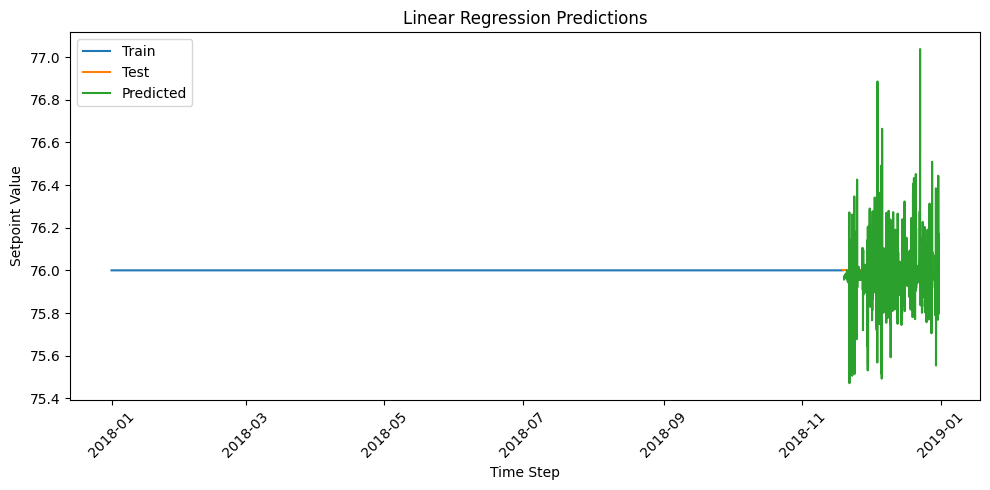

In [45]:
# Plot train, test and predictions
plt.figure(figsize=(10, 5))
plt.plot(heating_train_timeseries.index, heating_train_timeseries["setpoint"], label="Train")
plt.plot(heating_test_timeseries.index, heating_test_timeseries["setpoint"], label="Test")
plt.plot(heating_test_timeseries.index[13:], heating_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cooling

In [46]:
input_size = 69
hidden_size_1 = 64
hidden_size_2 = 32
output_size = 1

In [47]:
cooling_model = MLPModel(
    input_size, 
    hidden_size_1=hidden_size_1, 
    hidden_size_2=hidden_size_2,
    output_size=output_size)

In [48]:
# Loss and optimizer
cooling_criterion = nn.MSELoss()
cooling_optimizer = optim.Adam(cooling_model.parameters(), lr=0.0001)

In [49]:
num_epochs = 100
train(cooling_model, cooling_train_loader, cooling_criterion, cooling_optimizer, num_epochs)

/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/.env/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/100, Loss: 563.9291
Epoch 2/100, Loss: 30.8411
Epoch 3/100, Loss: 15.4773
Epoch 4/100, Loss: 11.9703
Epoch 5/100, Loss: 9.3819
Epoch 6/100, Loss: 7.4120
Epoch 7/100, Loss: 6.0837
Epoch 8/100, Loss: 5.1872
Epoch 9/100, Loss: 4.5494
Epoch 10/100, Loss: 4.0601
Epoch 11/100, Loss: 3.6118
Epoch 12/100, Loss: 3.2449
Epoch 13/100, Loss: 2.9304
Epoch 14/100, Loss: 2.6816
Epoch 15/100, Loss: 2.4916
Epoch 16/100, Loss: 2.3295
Epoch 17/100, Loss: 2.1643
Epoch 18/100, Loss: 2.0472
Epoch 19/100, Loss: 1.9314
Epoch 20/100, Loss: 1.8446
Epoch 21/100, Loss: 1.7652
Epoch 22/100, Loss: 1.7128
Epoch 23/100, Loss: 1.6318
Epoch 24/100, Loss: 1.5776
Epoch 25/100, Loss: 1.5474
Epoch 26/100, Loss: 1.5196
Epoch 27/100, Loss: 1.4775
Epoch 28/100, Loss: 1.4441
Epoch 29/100, Loss: 1.4246
Epoch 30/100, Loss: 1.3863
Epoch 31/100, Loss: 1.3618
Epoch 32/100, Loss: 1.3492
Epoch 33/100, Loss: 1.3458
Epoch 34/100, Loss: 1.3383
Epoch 35/100, Loss: 1.2955
Epoch 36/100, Loss: 1.2890
Epoch 37/100, Loss: 1.2710
Epoch

In [50]:
# Predict
cooling_predictions, cooling_actuals = evaluate(cooling_model, cooling_test_loader)

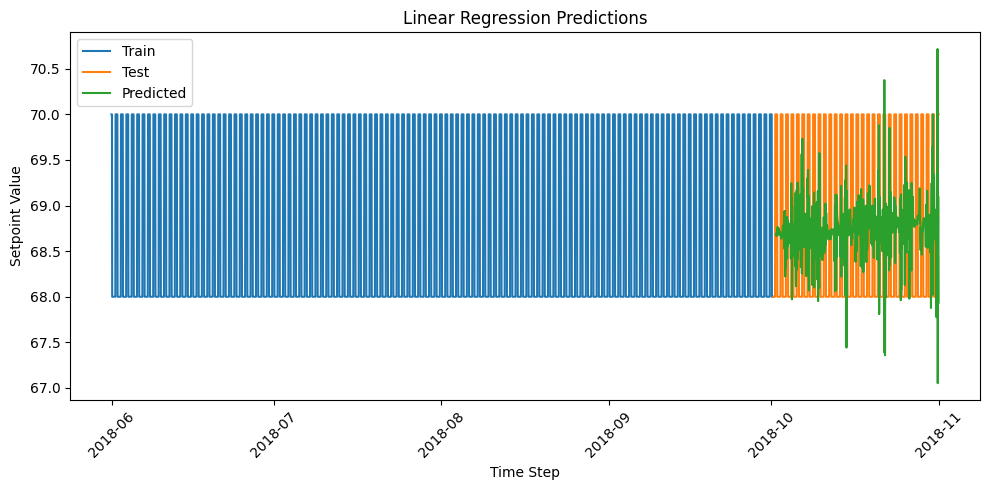

In [51]:
# Plot train, test and predictions
plt.figure(figsize=(10, 5))
plt.plot(cooling_train_timeseries.index, cooling_train_timeseries["setpoint"], label="Train")
plt.plot(cooling_test_timeseries.index, cooling_test_timeseries["setpoint"], label="Test")
plt.plot(cooling_test_timeseries.index[13:], cooling_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Akaike

In [52]:
def compute_aic(y_true, y_pred, num_params):
    n = y_true.numel()
    residuals = y_true - y_pred
    rss = torch.sum(residuals ** 2).item()
    sigma2 = rss / n
    log_likelihood = -n/2 * (np.log(2 * np.pi * sigma2) + 1)
    aic = 2 * num_params - 2 * log_likelihood
    return aic

In [53]:
heating_num_params = sum(p.numel() for p in heating_model.parameters() if p.requires_grad)

In [54]:
heating_aic = compute_aic(
    torch.tensor(heating_actuals), 
    torch.tensor(heating_predictions), 
    heating_num_params
)

In [55]:
heating_aic

np.float64(18910.148524170556)

In [56]:
cooling_num_params = sum(p.numel() for p in cooling_model.parameters() if p.requires_grad)
cooling_aic = compute_aic(
    torch.tensor(cooling_actuals), 
    torch.tensor(cooling_predictions), 
    cooling_num_params
)
cooling_aic

np.float64(20006.50738116355)

# ARIMA

## Add lag to variables

In [57]:
import warnings
warnings.filterwarnings("ignore")

# Add lag of 1 to consumption, and create new temperature column with lag 1
heating_exog_train["temperature_lag_1"] = heating_exog_train["temperature"].shift(1)
heating_exog_train["consumption_lag_1"] = heating_exog_train["consumption"].shift(1)
heating_exog_train.drop(columns=["consumption"], inplace=True)
heating_exog_train.bfill(inplace=True)

heating_exog_test["temperature_lag_1"] = heating_exog_test["temperature"].shift(1)
heating_exog_test["consumption_lag_1"] = heating_exog_test["consumption"].shift(1)
heating_exog_test.drop(columns=["consumption"], inplace=True)
heating_exog_test.bfill(inplace=True)

cooling_exog_train["temperature_lag_1"] = cooling_exog_train["temperature"].shift(1)
cooling_exog_train["consumption_lag_1"] = cooling_exog_train["consumption"].shift(1)
cooling_exog_train.drop(columns=["consumption"], inplace=True)
cooling_exog_train.bfill(inplace=True)

cooling_exog_test["temperature_lag_1"] = cooling_exog_test["temperature"].shift(1)
cooling_exog_test["consumption_lag_1"] = cooling_exog_test["consumption"].shift(1)
cooling_exog_test.drop(columns=["consumption"], inplace=True)
cooling_exog_test.bfill(inplace=True)

In [58]:
heating_exog_train.head()

,temperature,Direct Normal Radiation [W/m2],temperature_lag_1,consumption_lag_1
timestamp,,,,
2018-01-01 00:00:00,-17.2,0.0,-17.2,4.691970
2018-01-01 01:00:00,-17.2,0.0,-17.2,4.691970
2018-01-01 02:00:00,-17.8,0.0,-17.2,5.008804
2018-01-01 03:00:00,-18.9,0.0,-17.8,4.799112
2018-01-01 04:00:00,-18.9,0.0,-18.9,4.963452


## Heating

In [59]:
# Make sure heating_endog_train and heating_exog_train have hourly frequency
heating_endog_train = heating_endog_train.asfreq('h')
heating_exog_train = heating_exog_train.asfreq('h')

heating_endog_train.ffill(inplace=True)
heating_exog_train.ffill(inplace=True)
heating_endog_train.bfill(inplace=True)
heating_exog_train.bfill(inplace=True)

In [76]:
heating_arima_model = ARIMA(
    endog=heating_endog_train,
    exog=heating_exog_train,
    order=(0, 0, 0),
    freq="h",
)

In [77]:
heating_arima_model_fit = heating_arima_model.fit()

In [78]:
print(heating_arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               setpoint   No. Observations:                 7724
Model:                          ARIMA   Log Likelihood               81827.955
Date:                Mon, 26 May 2025   AIC                        -163643.910
Time:                        10:20:39   BIC                        -163602.198
Sample:                    01-01-2018   HQIC                       -163629.607
                         - 11-18-2018                                         
Covariance Type:                  opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             76.0000   1.71e-23   4.44e+24      0.000      76.000      76.000
temperature                      2.19e-14   5.67e-23   3.86e+08      0.

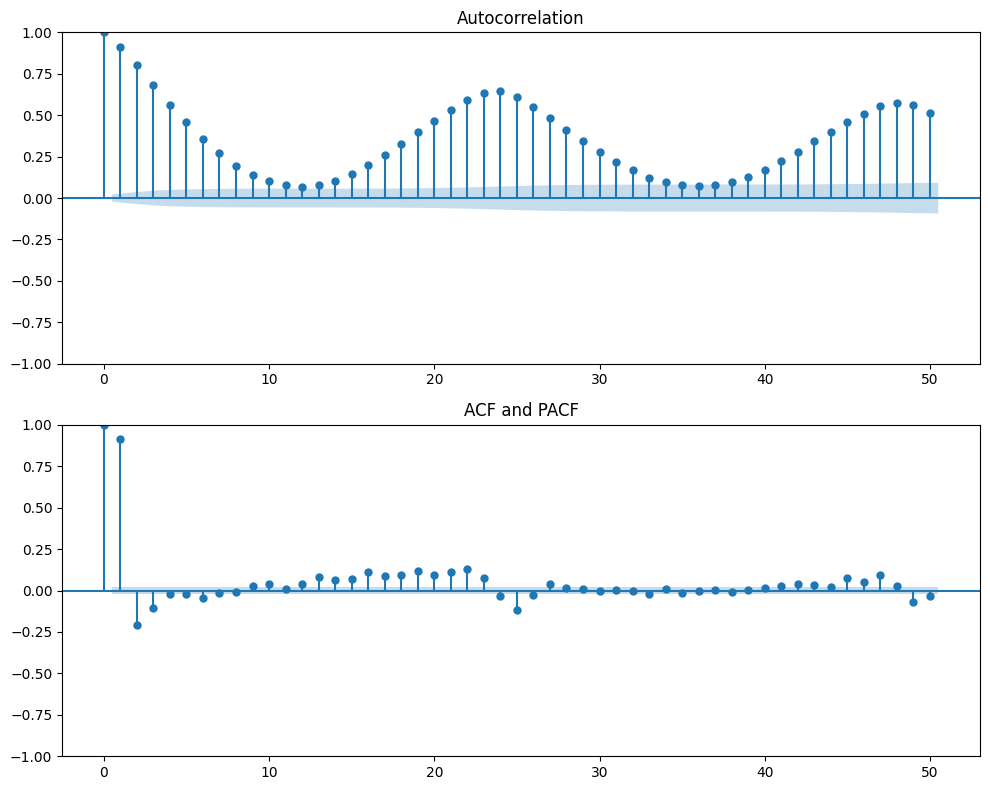

In [79]:
# Plot ACF and PACF

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(heating_arima_model_fit.resid, lags=50, ax=ax[0])
plot_pacf(heating_arima_model_fit.resid, lags=50, ax=ax[1])
plt.title("ACF and PACF")
plt.tight_layout()
plt.show()

In [80]:
# Predict
predictions = heating_arima_model_fit.get_forecast(steps=len(heating_endog_test), exog=heating_exog_test)
predicted_mean = predictions.predicted_mean
predicted_conf_int = predictions.conf_int()
lower_limits = predicted_conf_int.iloc[:, 0]
upper_limits = predicted_conf_int.iloc[:, 1]
predicted_mean = pd.Series(predicted_mean, index=heating_endog_test.index)

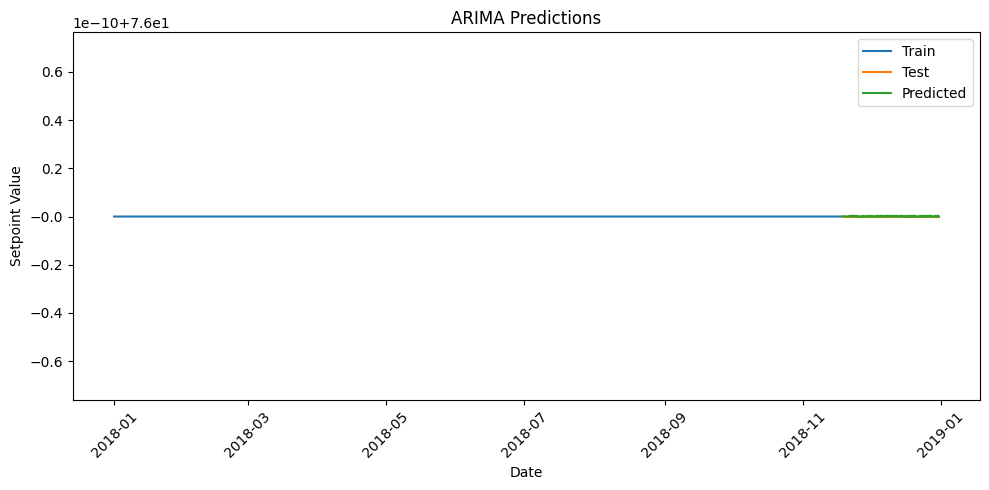

In [81]:
# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(heating_endog_train.index, heating_endog_train["setpoint"], label="Train")
plt.plot(heating_endog_test.index, heating_endog_test["setpoint"], label="Test")
plt.plot(predicted_mean.index, predicted_mean, label="Predicted")
plt.title("ARIMA Predictions")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [82]:
heating_arima_model_fit.params

const                             7.600000e+01
temperature                       2.189915e-14
Direct Normal Radiation [W/m2]    3.087266e-16
temperature_lag_1                -2.225997e-14
consumption_lag_1                 1.332268e-14
sigma2                            1.000000e-10
dtype: float64

## Cooling

In [66]:
# Make sure heating_endog_train and heating_exog_train have hourly frequency
cooling_endog_train = cooling_endog_train.asfreq('h')
cooling_exog_train = cooling_exog_train.asfreq('h')

cooling_endog_train.ffill(inplace=True)
cooling_exog_train.ffill(inplace=True)
cooling_endog_train.bfill(inplace=True)
cooling_exog_train.bfill(inplace=True)

In [90]:
cooling_arima_model = ARIMA(
    endog=cooling_endog_train,
    exog=cooling_exog_train,
    order=(1, 0, 0),
    seasonal_order=(1, 0, 0, 24),
    freq="h",
)

In [91]:
cooling_arima_model_fit = cooling_arima_model.fit()

In [92]:
print(cooling_arima_model_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                         setpoint   No. Observations:                 2937
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 24)   Log Likelihood                2491.832
Date:                          Mon, 26 May 2025   AIC                          -4967.664
Time:                                  10:26:05   BIC                          -4919.783
Sample:                              06-01-2018   HQIC                         -4950.423
                                   - 10-01-2018                                         
Covariance Type:                            opg                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             69.4682      0.032   2142.502      0.000      69.405    

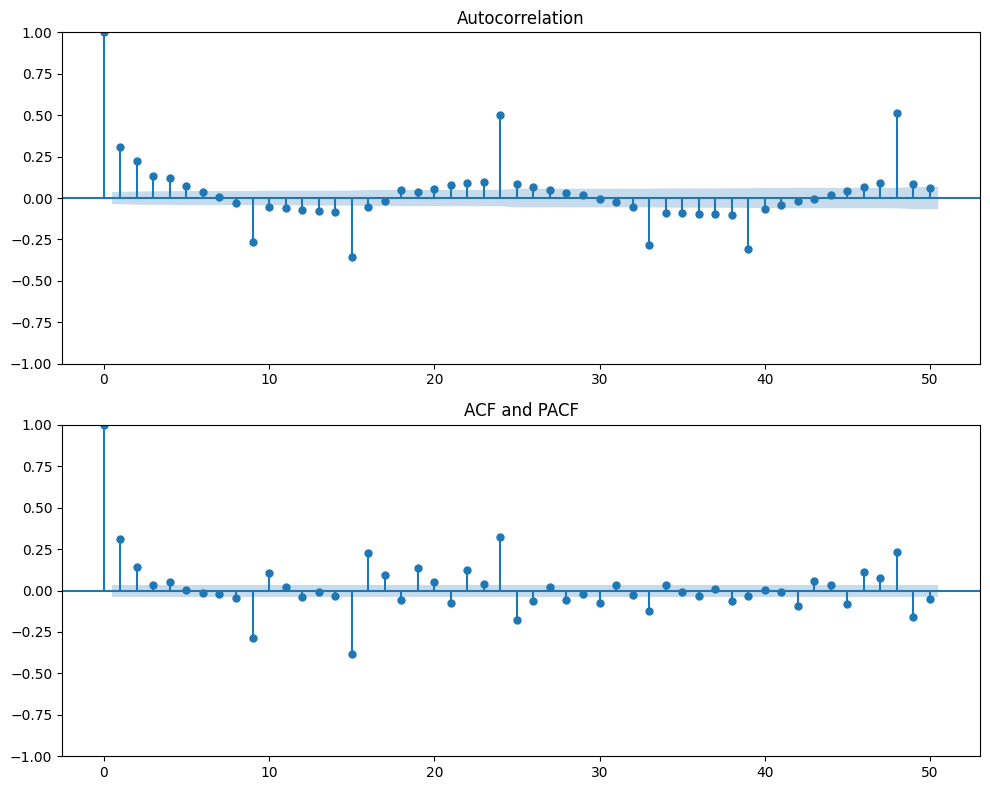

In [93]:
# Plot ACF and PACF

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(cooling_arima_model_fit.resid, lags=50, ax=ax[0])
plot_pacf(cooling_arima_model_fit.resid, lags=50, ax=ax[1])
plt.title("ACF and PACF")
plt.tight_layout()
plt.show()

In [94]:
# Predict
predictions = cooling_arima_model_fit.get_forecast(steps=len(cooling_endog_test), exog=cooling_exog_test)
predicted_mean = predictions.predicted_mean
predicted_conf_int = predictions.conf_int()
lower_limits = predicted_conf_int.iloc[:, 0]
upper_limits = predicted_conf_int.iloc[:, 1]
predicted_mean = pd.Series(predicted_mean, index=cooling_endog_test.index)

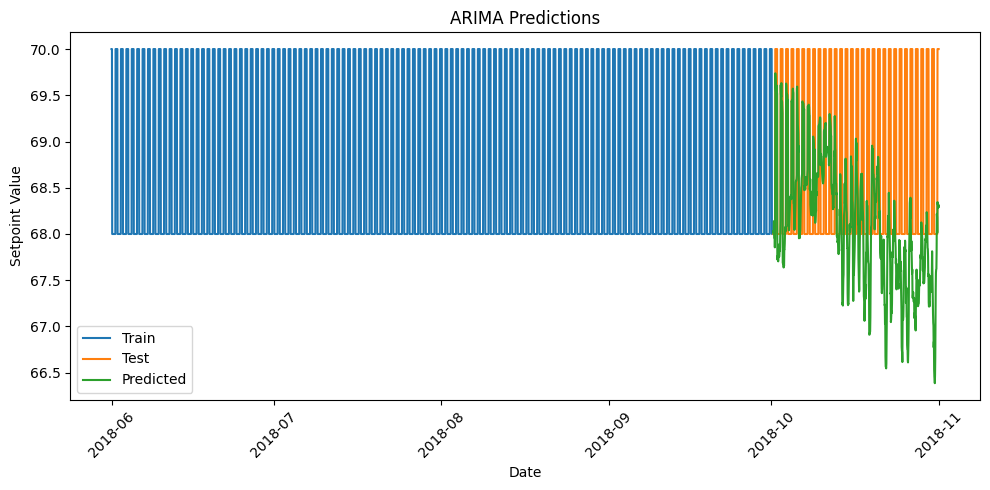

In [95]:
# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(cooling_endog_train.index, cooling_endog_train["setpoint"], label="Train")
plt.plot(cooling_endog_test.index, cooling_endog_test["setpoint"], label="Test")
plt.plot(predicted_mean.index, predicted_mean, label="Predicted")
plt.title("ARIMA Predictions")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [96]:
# Print arima parameters
print(cooling_arima_model_fit.params)

const                             69.468166
temperature                       -0.008926
Direct Normal Radiation [W/m2]    -0.000062
temperature_lag_1                 -0.013628
consumption_lag_1                 -1.540494
ar.L1                              0.693174
ar.S.L24                           0.852798
sigma2                             0.007526
dtype: float64
